# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.185411,False,0.252183
1,-0.676288,True,5.241772
2,-0.220051,False,-1.795438
3,-0.114103,False,1.241739
4,-2.685925,False,-1.354243
...,...,...,...
995,1.140466,True,8.066491
996,0.521374,True,4.571258
997,-0.145125,False,0.749062
998,-0.770367,False,0.884067


<AxesSubplot:xlabel='v0'>

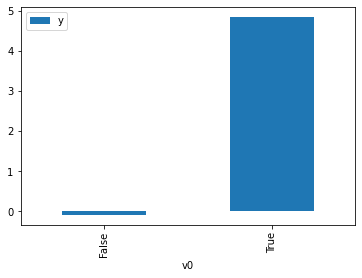

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

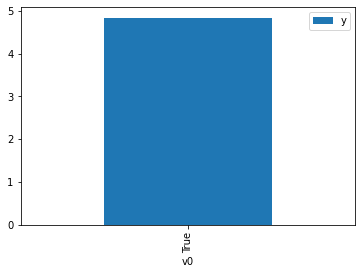

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.429884,False,0.449563,0.551111,1.814516
1,-0.220621,False,-2.315930,0.528463,1.892281
2,-2.287906,False,-1.048880,0.733961,1.362470
3,-0.114639,False,0.456186,0.516941,1.934456
4,1.406420,False,2.302282,0.355482,2.813078
...,...,...,...,...,...
995,1.577663,False,-0.204587,0.338576,2.953547
996,0.843253,False,-0.685070,0.413475,2.418529
997,-0.186478,False,1.056377,0.524754,1.905656
998,-0.892383,False,0.459187,0.600296,1.665844


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.714833,True,3.896052,0.572892,1.745530
1,-0.380756,True,5.254550,0.454190,2.201720
2,-1.386157,True,5.381636,0.349357,2.862403
3,0.160349,True,5.975798,0.513007,1.949293
4,-0.473289,True,3.901127,0.444214,2.251166
...,...,...,...,...,...
995,1.012825,True,4.458636,0.604324,1.654743
996,-0.506199,True,5.135710,0.440677,2.269238
997,-1.121886,True,3.532041,0.375965,2.659819
998,-0.630965,True,4.777884,0.427322,2.340155


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              6228.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                        0.00
Time:                        08:54:39   Log-Likelihood:                         -1386.1
No. Observations:                1000   AIC:                                      2776.
Df Residuals:                     998   BIC:                                      2786.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3881      0.030     12.966      0.000       0.329       0.447
x2             4.9378      0.045    110.860      0.000       4.850       5.025
==============================================================================
Omnibus:                        1.354   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.508   Jarque-Bera (JB):                1.419
Skew:                           0.064   Prob(JB):                        0.492
Kurtosis:                       2.867   Cond. No.                         1.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""